## Base Imports and Tensorflow

In [1]:
# import base libraries and Tensoflow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model


%matplotlib inline
print(tf.__version__)

2.0.0


## Setup azure workspace for Data & Labels

In [2]:
#import for Azure data
from azureml.core import Dataset, Datastore, Workspace, Experiment, ComputeTarget
# import azureml.contrib.dataset
# from azureml.contrib.dataset import FileHandlingOption, LabeledDatasetTask
from azureml.core.authentication import InteractiveLoginAuthentication
import os
from pathlib import Path, PurePosixPath, PureWindowsPath

In [3]:
df_lab = pd.read_csv('../../datasets/animals/labels.csv')
df_lab.head()

,FilePath,Label
0,cats/cats_00072.jpg,cat
1,cats/cats_00073.jpg,cat
2,cats/cats_00074.jpg,cat
3,cats/cats_00075.jpg,cat
4,cats/cats_00076.jpg,cat


In [4]:
# Set data directory to where images are
data_dir = '../../datasets/animals'

In [5]:
# get file paths and labels from label df
file_paths_and_labels_df = df_lab

In [6]:
file_paths_and_labels_df.head()

,FilePath,Label
0,cats/cats_00072.jpg,cat
1,cats/cats_00073.jpg,cat
2,cats/cats_00074.jpg,cat
3,cats/cats_00075.jpg,cat
4,cats/cats_00076.jpg,cat


In [7]:
file_paths_and_labels_df.shape

(2850, 2)

In [8]:
# TODO SET RANDOM SEEDS

In [9]:
# Model Params

# Image height & width
img_height = 128
img_width = 128
img_depth = 3

IMG_SHAPE = (img_height, img_width, img_depth)


# initialize learning rate, batch size, and number of epochs
INIT_LR =  0.001
BATCH_SIZE = 32
NUM_EPOCHS = 300

# initialize the label names if needed
num_classes = 3


## Data Generators

How the model will read in Data. 
We can add augmentations here

This gets our training data and validation data.

Our holdout test set will be seperate

In [10]:
Shuffle_file_paths_and_labels_df = file_paths_and_labels_df.sample(frac=1).reset_index(drop=True)


In [11]:
# Create Data Generators

train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_dataframe(
    dataframe=Shuffle_file_paths_and_labels_df,
    directory= data_dir,
    x_col="FilePath",
    y_col="Label",
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=Shuffle_file_paths_and_labels_df,
    directory = data_dir,
    x_col="FilePath",
    y_col="Label",
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 2280 validated image filenames belonging to 3 classes.
Found 570 validated image filenames belonging to 3 classes.


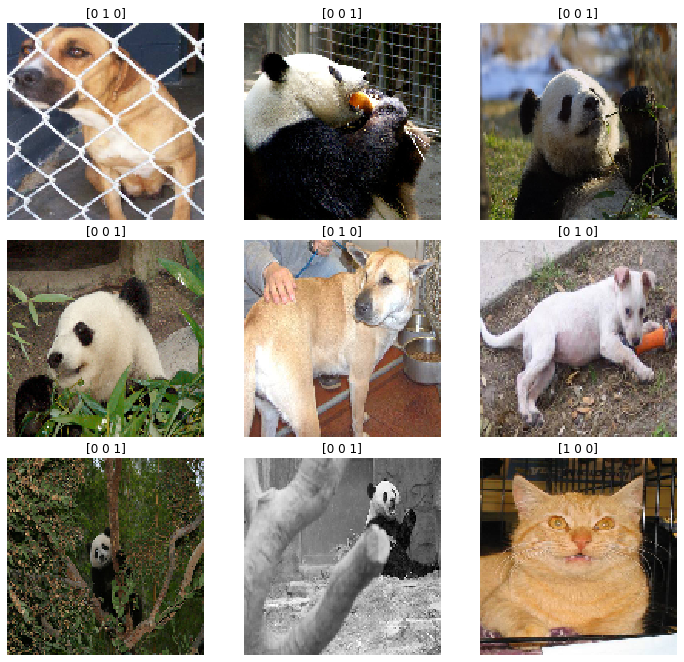

In [12]:
testX_sanity, testY_sanity = next(iter(validation_generator))

testY_sanity = testY_sanity.astype(int)

L = 3
W = 3

fig, axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(testX_sanity[i])
    axes[i].set_title('{}'.format(testY_sanity[i]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0)

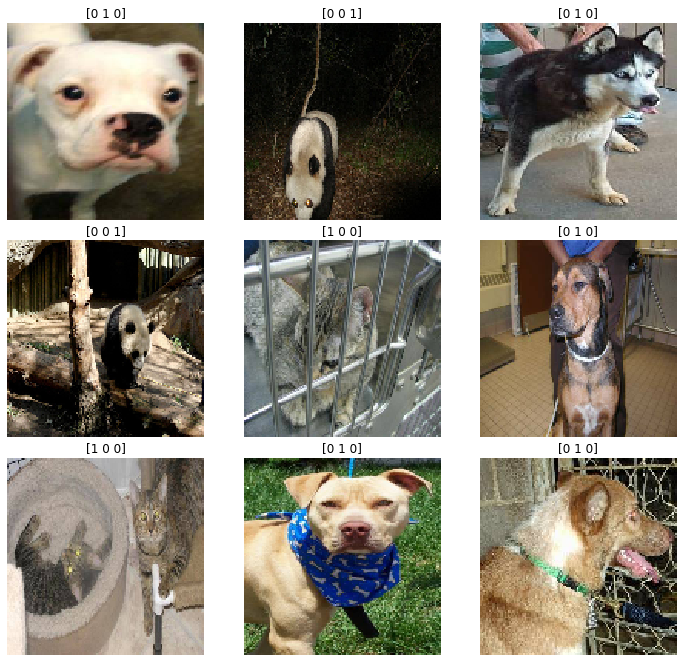

In [13]:
testX_sanity, testY_sanity = next(iter(train_generator))

testY_sanity = testY_sanity.astype(int)

L = 3
W = 3

fig, axes = plt.subplots(L,W,figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(testX_sanity[i])
    axes[i].set_title('{}'.format(testY_sanity[i]))
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0)

## Create Model

In [14]:
# Get Resnet50 model from TF
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [15]:
# load resnet model WITHOUT imagenet weights
# do not include avg pool layer & output dense layer
res_net50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [16]:
# summarize the model
res_net50v2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [17]:
x = res_net50v2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = res_net50v2.input, outputs = predictions)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
__________________________________________________________________________________________________


In [19]:
# initialize the optimizer and compile the model
print("[INFO] Initialize optimizer")
opt = SGD(lr=INIT_LR,
          momentum=0.9,
          decay=INIT_LR / NUM_EPOCHS)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])
 

[INFO] Initialize optimizer


In [20]:
# TODO Make Train Function

In [21]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS, 
    verbose=1)

Epoch 1/300
71/71 [==============================] - 22s 311ms/step - loss: 0.5566 - accuracy: 0.7665 - val_loss: 0.2369 - val_accuracy: 0.9357
Epoch 2/300
71/71 [==============================] - 18s 258ms/step - loss: 0.1773 - accuracy: 0.9399 - val_loss: 0.1860 - val_accuracy: 0.9412
Epoch 3/300
71/71 [==============================] - 18s 256ms/step - loss: 0.1037 - accuracy: 0.9693 - val_loss: 0.2374 - val_accuracy: 0.9265
Epoch 4/300
15/71 [=====>........................] - ETA: 13s - loss: 0.1298 - accuracy: 0.9671

KeyboardInterrupt: 

In [ ]:
break

In [ ]:
# model.save('outputs/weights.hdf5')

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
break

In [ ]:
#plt.savefig('foo.png')